##### 이 노트북은 문서 분류 대회를 위한 실험 노트북입니다.

In [1]:
# 새로운 셀 (맨 위)
%load_ext autoreload
%autoreload 2

print("✅ Auto-reload 활성화 - 파일 변경 자동 감지")

✅ Auto-reload 활성화 - 파일 변경 자동 감지


In [2]:
# ============================================================
# 1. Python path 설정, 라이브러리 임포트
# ============================================================
import sys
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
import numpy as np
from tqdm import tqdm

%matplotlib inline

project_root = Path.cwd() / "CV_competition_practice"
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root 생성 및 라이브러리 임포트 완료")

Project root 생성 및 라이브러리 임포트 완료


In [4]:
# ============================================================
# 2. Config 설정
# ============================================================
from src.config import QuickTestConfig, DocumentConfig
from src.utils import set_seed

# ============================================================
# Config 선택 (원하는 것만 주석 해제)
# ============================================================

# 방법 1: 빠른 테스트 (10% 데이터, 2 epoch, 2 fold)
config = QuickTestConfig()

# 방법 2: 문서 분류 대회 (전체 데이터, 100 epoch, 5 fold)
# config = DocumentConfig()

# ============================================================
# Seed 고정 (재현성 확보)
# ============================================================
set_seed(config.SEED)

# ============================================================
# Config 출력
# ============================================================
config.print_config()

# ============================================================
# 앙상블 실험
# ============================================================

# 1단계: 빠른 실험 (단일 모델)
#config.update(N_FOLDS=1, USE_TTA=False)
# → 빠르게 augmentation, 하이퍼파라미터 테스트

# 2단계: 중간 검증 (기본 앙상블)
#config.update(N_FOLDS=5, USE_TTA=False)
# → 모델 성능 확인

# 3단계: 최종 제출 (풀 앙상블 + TTA)
#config.update(N_FOLDS=5, USE_TTA=True)
# → 최고 성능으로 제출
# ============================================================
# 세부 설정 수정 (필요시)
# ============================================================
# 일부 파라미터만 바꾸고 싶을 때 update() 사용

# 예시 1: Epoch와 Batch Size만 수정
#config.update(
#     EPOCHS=5,
#     N_FOLDS=5
#)

# 예시 2: 서브셋 비율 변경 (20%만 사용)
# config.update(
#     USE_SUBSET=True,
#     SUBSET_RATIO=0.2
# )

# 예시 3: 모델 변경
# config.update(
#     MODEL_NAME='resnet50',
#     IMAGE_SIZE=224
# )

# 예시 4: 학습률과 Early Stopping 조정
# config.update(
#     LR=0.0001,
#     PATIENCE=10
# )

# 예시 5: K-Fold 수 변경
# config.update(
#     N_FOLDS=5
# )

# 예시 6: Wandb 켜기
# config.update(
#     USE_WANDB=True
# )

# 예시 7: 여러 개 한번에 수정
# config.update(
#     MODEL_NAME='efficientnet_b0',
#     BATCH_SIZE=64,
#     EPOCHS=20,
#     LR=0.001,
#     N_FOLDS=3,
#     USE_SUBSET=True,
#     SUBSET_RATIO=0.15
# )

# ============================================================
# 또는 직접 속성 수정도 가능
# ============================================================
# config.EPOCHS = 10
# config.BATCH_SIZE = 64
# config.print_config()  # 변경사항 확인

Seed set: 42 (MPS)
⚙️  실험 설정 (Hyperparameters)

📦 데이터셋 설정:
  - 데이터셋:          document
  - 이미지 크기:       224x224
  - 서브셋 사용:       No

🎨 Augmentation 설정:
  - 전략:              albumentations

🤖 모델 설정:
  - 모델:              efficientnet_b0
  - 클래스 수:         17

🎯 학습 설정:
  - Batch Size:        64
  - Epochs:            5
  - Learning Rate:     0.001
  - K-Fold:            5
  - Early Stop:        5 epochs

🖥️  디바이스:
  - Device:            mps


In [5]:
# ============================================================
# 3. 데이터 로드
# ============================================================
from src.data import load_data

# 데이터 로드
train_dataset_raw, test_dataset, train_labels, class_names, num_classes = load_data(config)

# ✅ 실제 클래스 수로 config 업데이트 (중요!)
if num_classes != config.NUM_CLASSES:
    print(f"\n⚠️  Config의 NUM_CLASSES ({config.NUM_CLASSES})와 실제 클래스 수 ({num_classes})가 다릅니다!")
    print(f"✅ Config를 실제 클래스 수로 업데이트합니다...")
    config.NUM_CLASSES = num_classes
    print(f"✅ Config 업데이트 완료: NUM_CLASSES = {config.NUM_CLASSES}")

print(f"\n📊 데이터 정보:")
print(f"  - 클래스 수: {num_classes}")
print(f"  - 클래스 이름: {class_names}")
print(f"  - 학습 샘플 수: {len(train_dataset_raw)}")
print(f"  - 테스트 샘플 수: {len(test_dataset) if test_dataset else 0}")
print(f"  - Device: {config.DEVICE}")


🎯 Dataset Type: document
📄 Loading Document Classification Data

✅ Document Data Loaded!
Total samples: 1,570
Number of classes: 17
Class names: ['account_number', 'application_for_payment_of_pregnancy_medical_expenses', 'car_dashboard', 'confirmation_of_admission_and_discharge', 'diagnosis']...
Test samples: 3,140

📊 데이터 정보:
  - 클래스 수: 17
  - 클래스 이름: ['account_number', 'application_for_payment_of_pregnancy_medical_expenses', 'car_dashboard', 'confirmation_of_admission_and_discharge', 'diagnosis', 'driver_lisence', 'medical_bill_receipts', 'medical_outpatient_certificate', 'national_id_card', 'passport', 'payment_confirmation', 'pharmaceutical_receipt', 'prescription', 'resume', 'statement_of_opinion', 'vehicle_registration_certificate', 'vehicle_registration_plate']
  - 학습 샘플 수: 1570
  - 테스트 샘플 수: 3140
  - Device: mps


In [6]:
# ============================================================
# 데이터 로드 확인
# ============================================================
print(f"\n📊 현재 데이터 상태:")
print(f"  - 학습 데이터: {len(train_dataset_raw)} 샘플")
print(f"  - 테스트 데이터: {len(test_dataset) if test_dataset else 0} 샘플")
print(f"  - 클래스 수: {num_classes}")
print(f"  - 클래스 이름: {class_names}")

# 첫 번째 샘플 확인
sample_img, sample_label = train_dataset_raw[0]
print(f"\n샘플 확인:")
print(f"  - 이미지 shape: {sample_img.size if hasattr(sample_img, 'size') else type(sample_img)}")
print(f"  - 레이블: {sample_label} ({class_names[sample_label]})")



📊 현재 데이터 상태:
  - 학습 데이터: 1570 샘플
  - 테스트 데이터: 3140 샘플
  - 클래스 수: 17
  - 클래스 이름: ['account_number', 'application_for_payment_of_pregnancy_medical_expenses', 'car_dashboard', 'confirmation_of_admission_and_discharge', 'diagnosis', 'driver_lisence', 'medical_bill_receipts', 'medical_outpatient_certificate', 'national_id_card', 'passport', 'payment_confirmation', 'pharmaceutical_receipt', 'prescription', 'resume', 'statement_of_opinion', 'vehicle_registration_certificate', 'vehicle_registration_plate']

샘플 확인:
  - 이미지 shape: 785439
  - 레이블: 16 (vehicle_registration_plate)


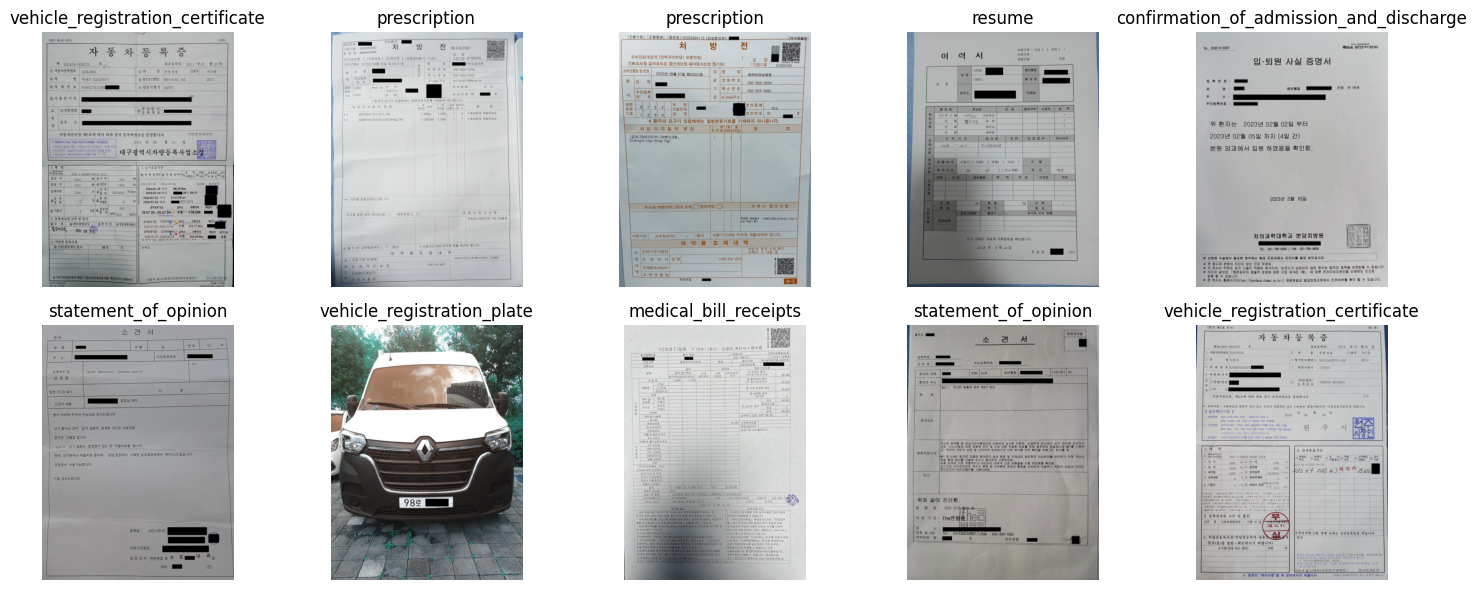

In [7]:
# ============================================================
# 4. 샘플 이미지 시각화 (랜덤)
# ============================================================
import random
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# 랜덤 인덱스 생성
random_indices = random.sample(range(len(train_dataset_raw)), 10)

for i, ax in enumerate(axes.flat):
    image, label = train_dataset_raw[random_indices[i]]
    ax.imshow(image)
    ax.set_title(f"{class_names[label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# ============================================================
# 5. 모델 생성
# ============================================================
from src.model import get_model, print_model_info, print_model_list, get_optimizer
import torch.nn as nn

# 모델 리스트 보기 (선택 사항)
# print_model_list(config.MODEL_NAME)

# 모델 생성
model = get_model(
    model_name=config.MODEL_NAME,
    num_classes=config.NUM_CLASSES,  # config에서 가져오기
    pretrained=True
)
model = model.to(config.DEVICE)  # ✅ device 대신 config.DEVICE 사용

# 모델 정보 출력
print_model_info(model, config.DEVICE, config.MODEL_NAME)

# Optimizer & Loss
optimizer = get_optimizer(model, config)
criterion = nn.CrossEntropyLoss()

print(f"\n✅ 학습 준비 완료")
print(f"Optimizer: Adam (lr={config.LR})")
print(f"Loss: CrossEntropyLoss")

✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)
   Pretrained weights 사용

📊 모델 정보
  모델 이름:           EfficientNet-B0
  전체 파라미터:       4,029,325
  학습 가능 파라미터:  4,029,325
  고정 파라미터:       0
  디바이스:            mps

✅ 학습 준비 완료
Optimizer: Adam (lr=0.001)
Loss: CrossEntropyLoss


In [ ]:
# ============================================================
# 6. Wandb 초기화
# ============================================================
wandb=None

if config.USE_WANDB:
    import wandb
    from src.model import MODEL_CONFIGS
    
    # Wandb 로그인 (최초 1회만, 주석 해제)
    # wandb.login()
    
    # 모델 display name
    model_display = MODEL_CONFIGS.get(
        config.MODEL_NAME, 
        {'display_name': config.MODEL_NAME}
    )['display_name']
    
    # 실험 이름
    run_name = f"{config.MODEL_NAME}_bs{config.BATCH_SIZE}_ep{config.EPOCHS}"
    if config.USE_SUBSET:
        run_name += f"_sub{int(config.SUBSET_RATIO*100)}"
    
    # Wandb 초기화
    wandb.init(
        project=config.WANDB_PROJECT,
        name=run_name,
        config=config.to_dict()  # Config 전체를 dict로 변환
    )
    
    print(f"✅ Wandb 초기화: {wandb.run.name}")
    print(f"📊 Project: {config.WANDB_PROJECT}")
else:
    print("⏭️  Wandb 비활성화")
    wandb = None  # 나중에 wandb 체크할 때 사용

In [9]:
# ============================================================
# 7. K-Fold 학습
# ============================================================
from src.train import run_kfold_training

# Config 기반으로 K-Fold 학습 실행
fold_results = run_kfold_training(
    train_dataset_raw=train_dataset_raw,
    train_labels=train_labels,
    config=config  # config에 num_classes, device, use_wandb 모두 포함
)

print("\n" + "="*60)
print("🎉 K-Fold 학습 완료!")
print("="*60)

# Fold별 결과 요약
print("\n📊 Fold별 결과:")
for fold_idx, result in enumerate(fold_results, 1):
    # ✅ 수정: best_val_f1 키 사용
    print(f"  Fold {fold_idx}: Val F1 = {result['best_val_f1']:.4f}")

# 평균 성능
avg_f1 = sum(r['best_val_f1'] for r in fold_results) / len(fold_results)

print(f"\n🎯 평균 성능:")
print(f"  평균 F1 Score: {avg_f1:.4f}")

🚀 K-Fold Cross Validation 시작
Model: efficientnet_b0, Epochs: 5, Batch: 64, Folds: 5

📁 Fold 1/5
Train: 1,256, Val: 314


/opt/anaconda3/envs/CV_competition/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/opt/anaconda3/envs/CV_competition/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)
   Pretrained weights 사용
✅ CrossEntropyLoss 사용

📍 Epoch [1/5]


Train - Loss: 1.4864 | Acc: 59.16% | F1: 0.5700
Val   - Loss: 0.3902 | Acc: 86.31% | F1: 0.8338
✅ Validation F1 improved (0.8338 → 0.8338)

📍 Epoch [2/5]


Train - Loss: 0.5163 | Acc: 82.96% | F1: 0.8205
Val   - Loss: 0.3496 | Acc: 88.85% | F1: 0.8694
✅ Validation F1 improved (0.8694 → 0.8694)

📍 Epoch [3/5]


Train - Loss: 0.3647 | Acc: 87.34% | F1: 0.8691
Val   - Loss: 0.5156 | Acc: 87.58% | F1: 0.8602
⏸️  EarlyStopping counter: 1/5

📍 Epoch [4/5]


Train - Loss: 0.2647 | Acc: 91.00% | F1: 0.9040
Val   - Loss: 0.3737 | Acc: 89.49% | F1: 0.8912
✅ Validation F1 improved (0.8912 → 0.8912)

📍 Epoch [5/5]


Train - Loss: 0.1902 | Acc: 92.91% | F1: 0.9250
Val   - Loss: 0.3501 | Acc: 90.76% | F1: 0.9036
✅ Validation F1 improved (0.9036 → 0.9036)

✅ Fold 1 완료! Best Val F1: 0.9036

📁 Fold 2/5
Train: 1,256, Val: 314


/opt/anaconda3/envs/CV_competition/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)
   Pretrained weights 사용

📍 Epoch [1/5]


Train - Loss: 1.3916 | Acc: 62.66% | F1: 0.6049
Val   - Loss: 0.5460 | Acc: 85.03% | F1: 0.8219
✅ Validation F1 improved (0.8219 → 0.8219)

📍 Epoch [2/5]


Train - Loss: 0.5386 | Acc: 82.80% | F1: 0.8138
Val   - Loss: 0.3032 | Acc: 88.85% | F1: 0.8864
✅ Validation F1 improved (0.8864 → 0.8864)

📍 Epoch [3/5]


Train - Loss: 0.3238 | Acc: 88.69% | F1: 0.8771
Val   - Loss: 0.3619 | Acc: 88.85% | F1: 0.8808
⏸️  EarlyStopping counter: 1/5

📍 Epoch [4/5]


Train - Loss: 0.3106 | Acc: 89.41% | F1: 0.8845
Val   - Loss: 0.3975 | Acc: 87.58% | F1: 0.8758
⏸️  EarlyStopping counter: 2/5

📍 Epoch [5/5]


Train - Loss: 0.1816 | Acc: 93.79% | F1: 0.9336
Val   - Loss: 0.2541 | Acc: 93.95% | F1: 0.9326
✅ Validation F1 improved (0.9326 → 0.9326)

✅ Fold 2 완료! Best Val F1: 0.9326

📁 Fold 3/5
Train: 1,256, Val: 314


/opt/anaconda3/envs/CV_competition/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)
   Pretrained weights 사용

📍 Epoch [1/5]


Train - Loss: 1.2864 | Acc: 62.42% | F1: 0.5983
Val   - Loss: 0.3756 | Acc: 85.03% | F1: 0.8275
✅ Validation F1 improved (0.8275 → 0.8275)

📍 Epoch [2/5]


Train - Loss: 0.4604 | Acc: 83.92% | F1: 0.8156
Val   - Loss: 0.2108 | Acc: 90.45% | F1: 0.8721
✅ Validation F1 improved (0.8721 → 0.8721)

📍 Epoch [3/5]


Train - Loss: 0.3018 | Acc: 89.65% | F1: 0.8851
Val   - Loss: 0.2058 | Acc: 91.72% | F1: 0.9078
✅ Validation F1 improved (0.9078 → 0.9078)

📍 Epoch [4/5]


Train - Loss: 0.2576 | Acc: 91.16% | F1: 0.9068
Val   - Loss: 0.2320 | Acc: 92.99% | F1: 0.9262
✅ Validation F1 improved (0.9262 → 0.9262)

📍 Epoch [5/5]


Train - Loss: 0.1946 | Acc: 94.03% | F1: 0.9401
Val   - Loss: 0.2654 | Acc: 90.13% | F1: 0.8896
⏸️  EarlyStopping counter: 1/5

✅ Fold 3 완료! Best Val F1: 0.9262

📁 Fold 4/5
Train: 1,256, Val: 314


/opt/anaconda3/envs/CV_competition/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)
   Pretrained weights 사용

📍 Epoch [1/5]


Train - Loss: 1.2997 | Acc: 63.54% | F1: 0.6138
Val   - Loss: 0.4111 | Acc: 86.31% | F1: 0.8259
✅ Validation F1 improved (0.8259 → 0.8259)

📍 Epoch [2/5]


Train - Loss: 0.4989 | Acc: 83.60% | F1: 0.8223
Val   - Loss: 0.3820 | Acc: 86.31% | F1: 0.8518
✅ Validation F1 improved (0.8518 → 0.8518)

📍 Epoch [3/5]


Train - Loss: 0.2890 | Acc: 89.01% | F1: 0.8844
Val   - Loss: 0.3883 | Acc: 88.85% | F1: 0.8796
✅ Validation F1 improved (0.8796 → 0.8796)

📍 Epoch [4/5]


Train - Loss: 0.2743 | Acc: 91.16% | F1: 0.9082
Val   - Loss: 0.4527 | Acc: 87.90% | F1: 0.8605
⏸️  EarlyStopping counter: 1/5

📍 Epoch [5/5]


Train - Loss: 0.2316 | Acc: 92.44% | F1: 0.9219
Val   - Loss: 0.3839 | Acc: 90.76% | F1: 0.8998
✅ Validation F1 improved (0.8998 → 0.8998)

✅ Fold 4 완료! Best Val F1: 0.8998

📁 Fold 5/5
Train: 1,256, Val: 314


/opt/anaconda3/envs/CV_competition/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)
   Pretrained weights 사용

📍 Epoch [1/5]


Train - Loss: 1.3763 | Acc: 60.51% | F1: 0.5805
Val   - Loss: 0.5133 | Acc: 83.12% | F1: 0.7922
✅ Validation F1 improved (0.7922 → 0.7922)

📍 Epoch [2/5]


Train - Loss: 0.5036 | Acc: 83.36% | F1: 0.8253
Val   - Loss: 0.3219 | Acc: 87.58% | F1: 0.8625
✅ Validation F1 improved (0.8625 → 0.8625)

📍 Epoch [3/5]


Train - Loss: 0.3482 | Acc: 88.54% | F1: 0.8739
Val   - Loss: 0.2958 | Acc: 90.45% | F1: 0.9017
✅ Validation F1 improved (0.9017 → 0.9017)

📍 Epoch [4/5]


Train - Loss: 0.2575 | Acc: 90.92% | F1: 0.9058
Val   - Loss: 0.2535 | Acc: 91.72% | F1: 0.9124
✅ Validation F1 improved (0.9124 → 0.9124)

📍 Epoch [5/5]


Train - Loss: 0.2081 | Acc: 92.83% | F1: 0.9233
Val   - Loss: 0.2581 | Acc: 92.36% | F1: 0.9183
✅ Validation F1 improved (0.9183 → 0.9183)

✅ Fold 5 완료! Best Val F1: 0.9183

📊 K-Fold 결과 요약
Fold 1: Best Val F1 = 0.9036
Fold 2: Best Val F1 = 0.9326
Fold 3: Best Val F1 = 0.9262
Fold 4: Best Val F1 = 0.8998
Fold 5: Best Val F1 = 0.9183
📈 평균 Validation F1: 0.9161 ± 0.0127

⏭️  Model saving disabled (SAVE_MODEL=False)

🎉 K-Fold 학습 완료!

📊 Fold별 결과:
  Fold 1: Val F1 = 0.9036
  Fold 2: Val F1 = 0.9326
  Fold 3: Val F1 = 0.9262
  Fold 4: Val F1 = 0.8998
  Fold 5: Val F1 = 0.9183

🎯 평균 성능:
  평균 F1 Score: 0.9161


🚀 전체 평가 프로세스 시작

📈 학습 곡선 시각화...


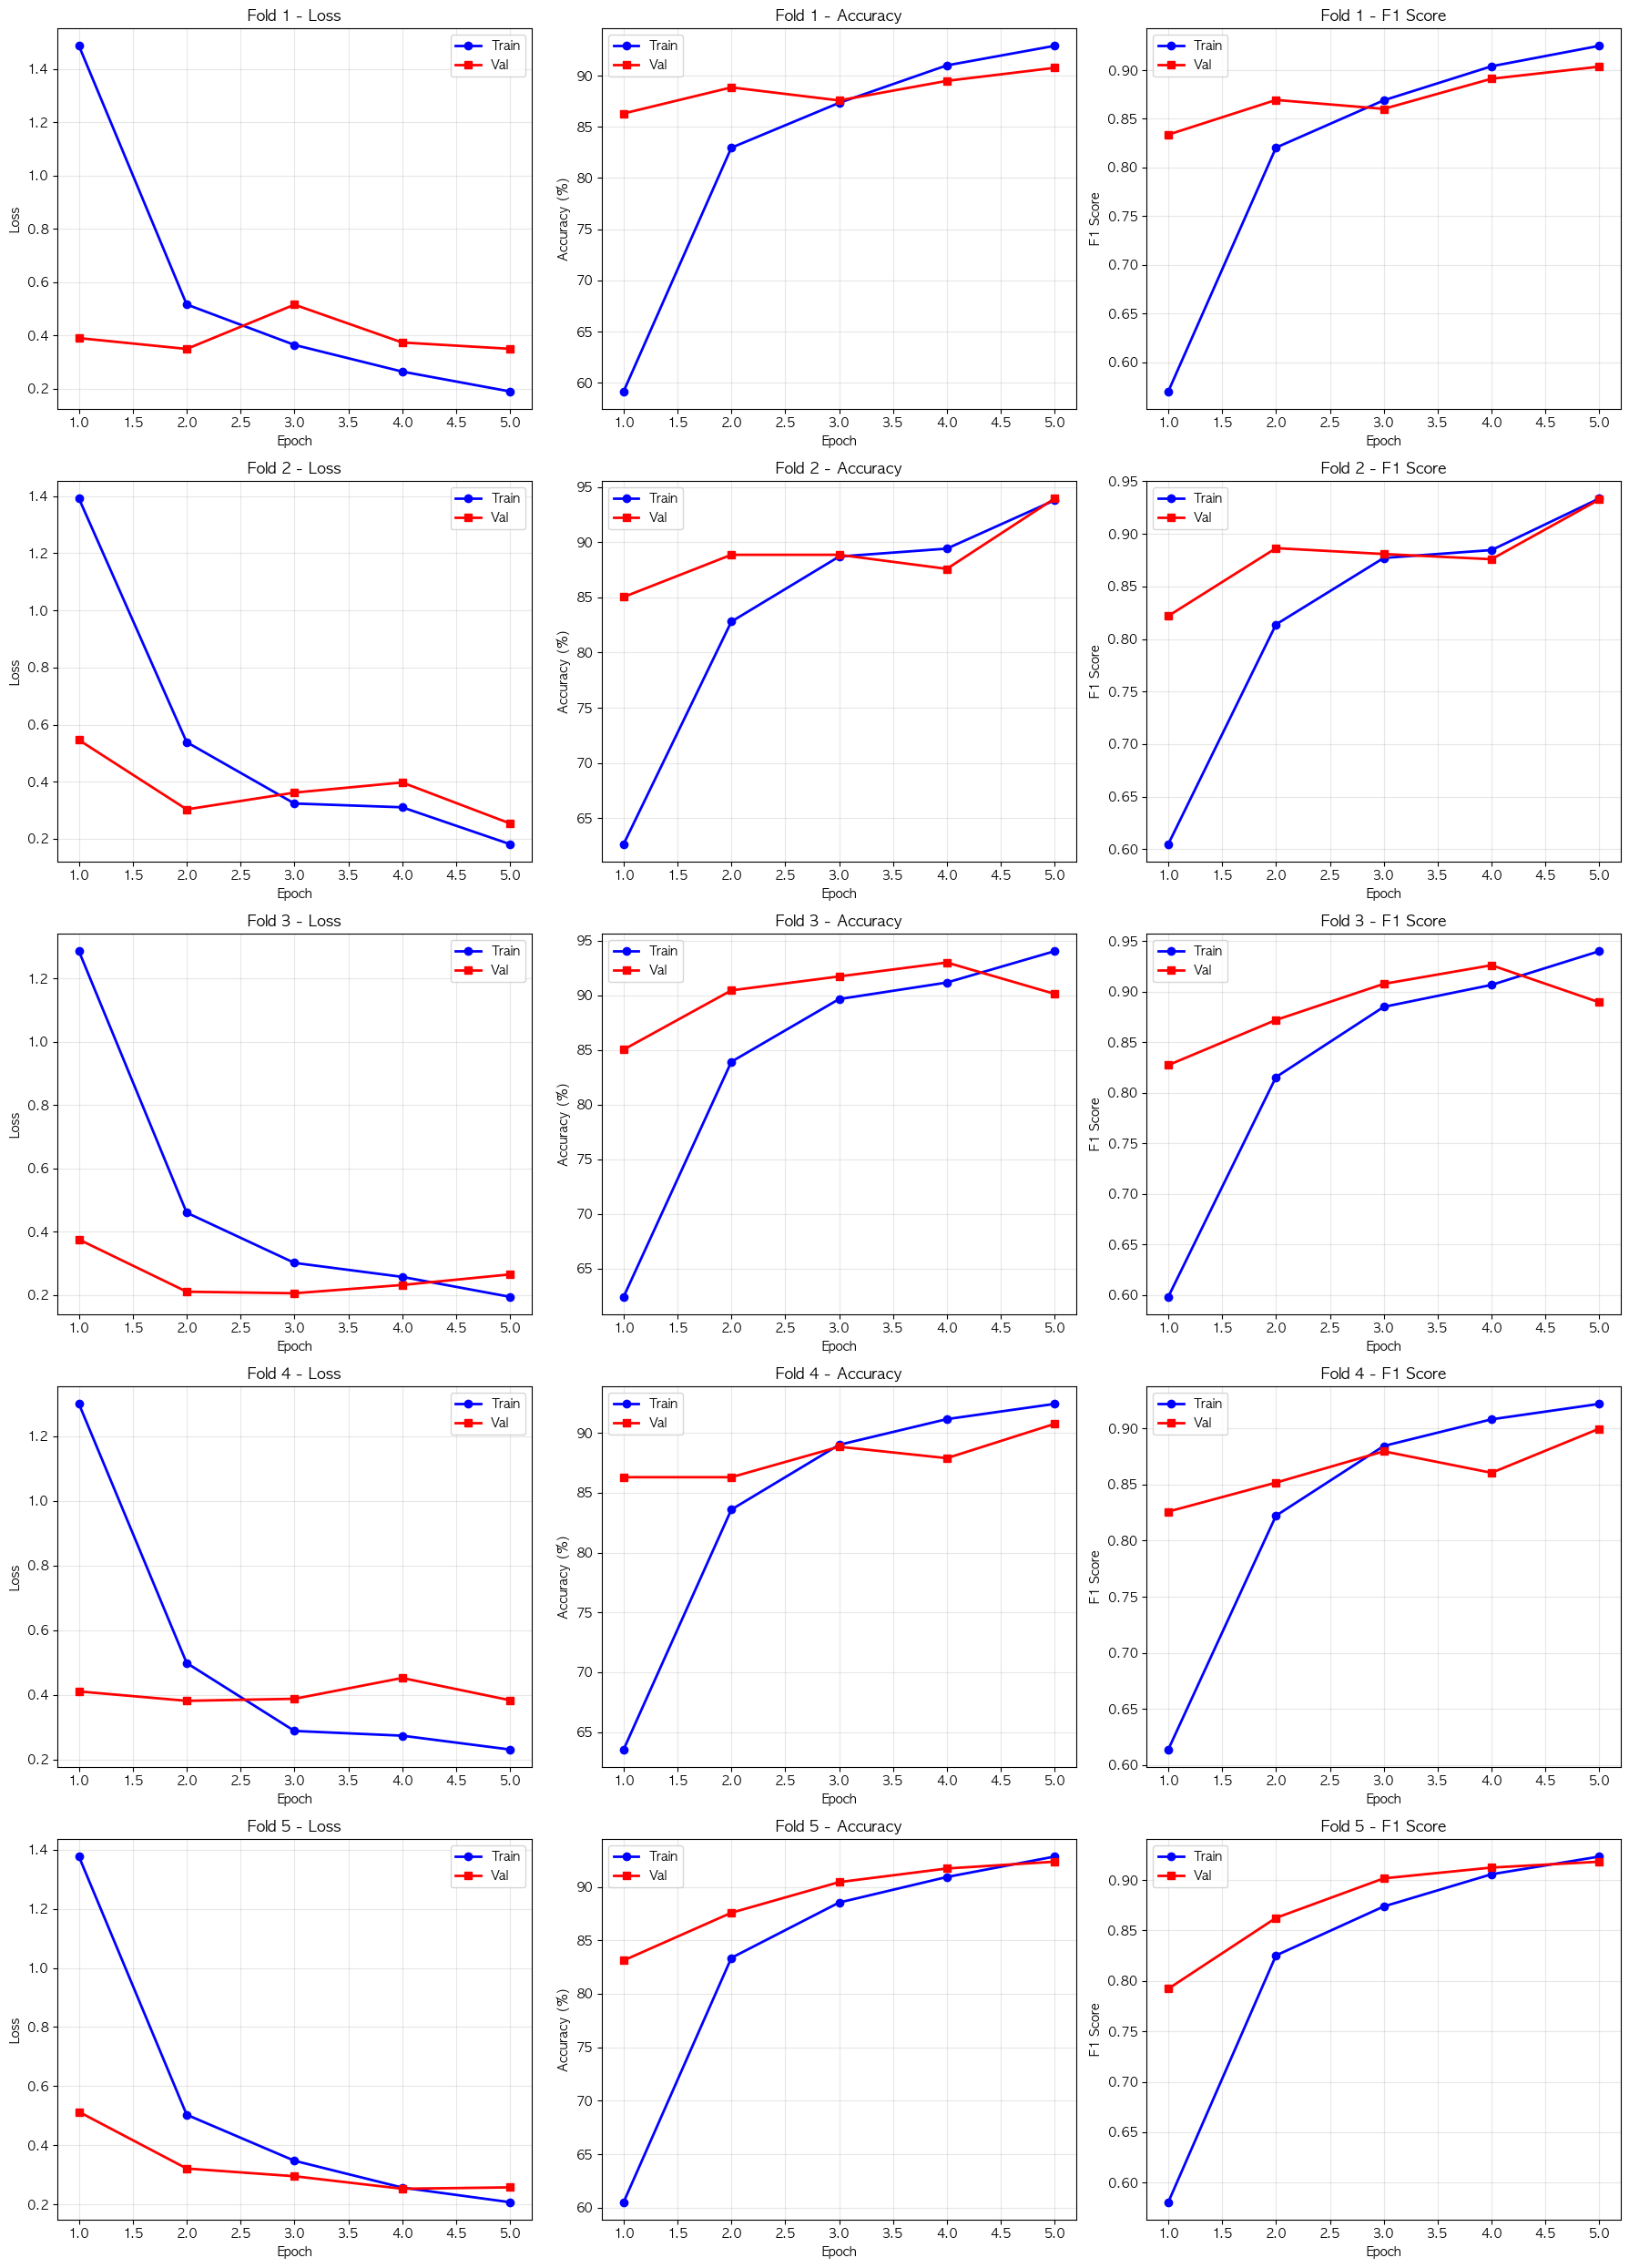

✅ 학습 곡선 시각화 완료!

🔮 Validation 앙상블 예측 시작...

📁 Fold 1 Validation 예측...
✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)


Fold 1: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


✅ Fold 1 Validation 예측 완료!

📁 Fold 2 Validation 예측...
✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)


Fold 2: 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


✅ Fold 2 Validation 예측 완료!

📁 Fold 3 Validation 예측...
✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)


Fold 3: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


✅ Fold 3 Validation 예측 완료!

📁 Fold 4 Validation 예측...
✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)


Fold 4: 100%|██████████| 5/5 [00:01<00:00,  4.08it/s]


✅ Fold 4 Validation 예측 완료!

📁 Fold 5 Validation 예측...
✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)


Fold 5: 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]


✅ Fold 5 Validation 예측 완료!

🎯 Validation Set 앙상블 결과
Validation Accuracy: 92.17%
Validation Macro F1 Score: 0.9171

📊 Confusion Matrix 생성...


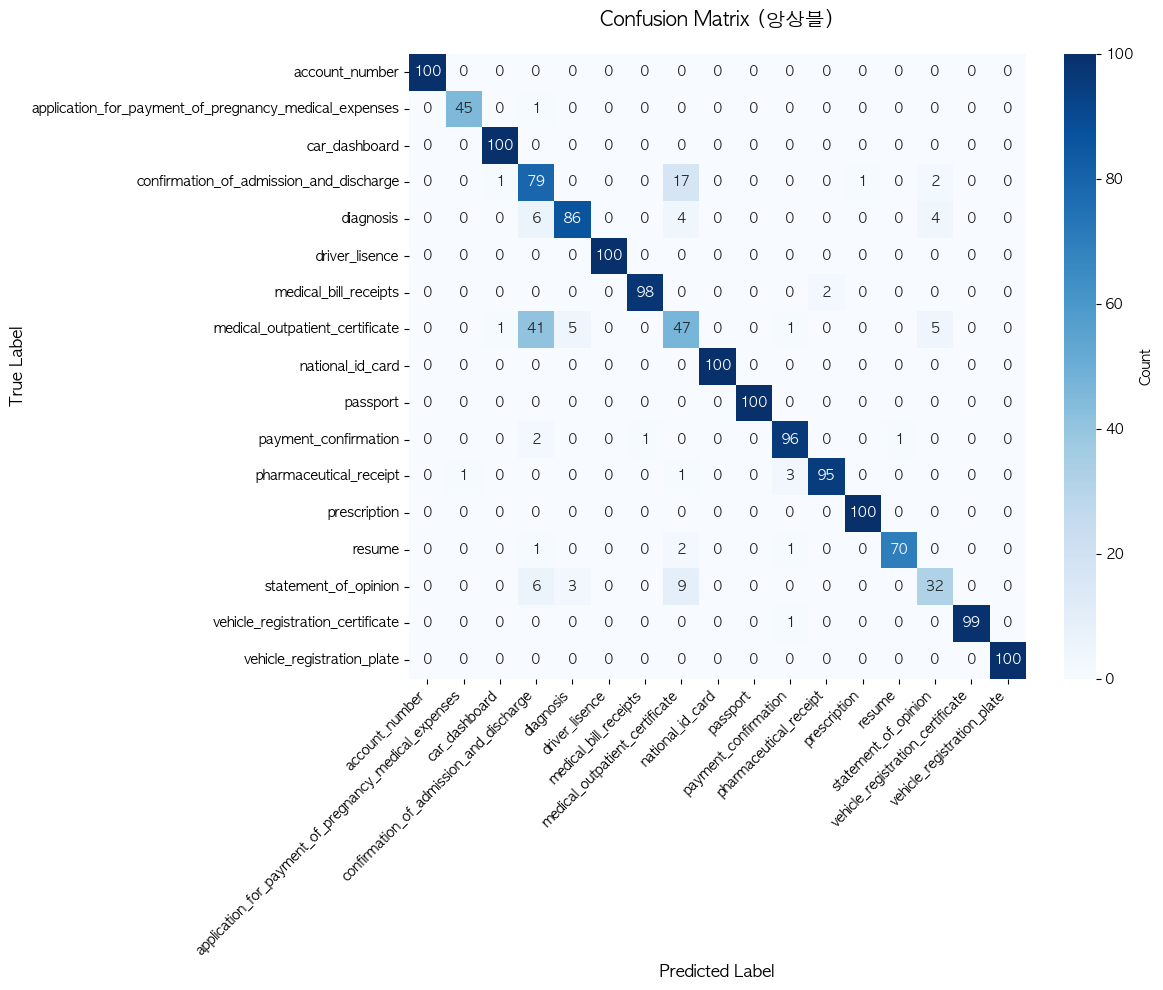


📊 클래스별 정확도
account_number      : 100.00% (100/100)
application_for_payment_of_pregnancy_medical_expenses: 97.83% (45/46)
car_dashboard       : 100.00% (100/100)
confirmation_of_admission_and_discharge: 79.00% (79/100)
diagnosis           : 86.00% (86/100)
driver_lisence      : 100.00% (100/100)
medical_bill_receipts: 98.00% (98/100)
medical_outpatient_certificate: 47.00% (47/100)
national_id_card    : 100.00% (100/100)
passport            : 100.00% (100/100)
payment_confirmation: 96.00% (96/100)
pharmaceutical_receipt: 95.00% (95/100)
prescription        : 100.00% (100/100)
resume              : 94.59% (70/74)
statement_of_opinion: 64.00% (32/50)
vehicle_registration_certificate: 99.00% (99/100)
vehicle_registration_plate: 100.00% (100/100)

🔍 오분류 분석...

📊 오분류 분석 결과
전체 테스트 샘플: 1,570개
정확히 예측: 1,447개 (92.17%)
오분류: 123개 (7.83%)

📈 가장 많이 틀린 클래스 조합 (Top 10):
----------------------------------------------------------------------
medical_outpatient_certificate → confirmation_of_admission_and

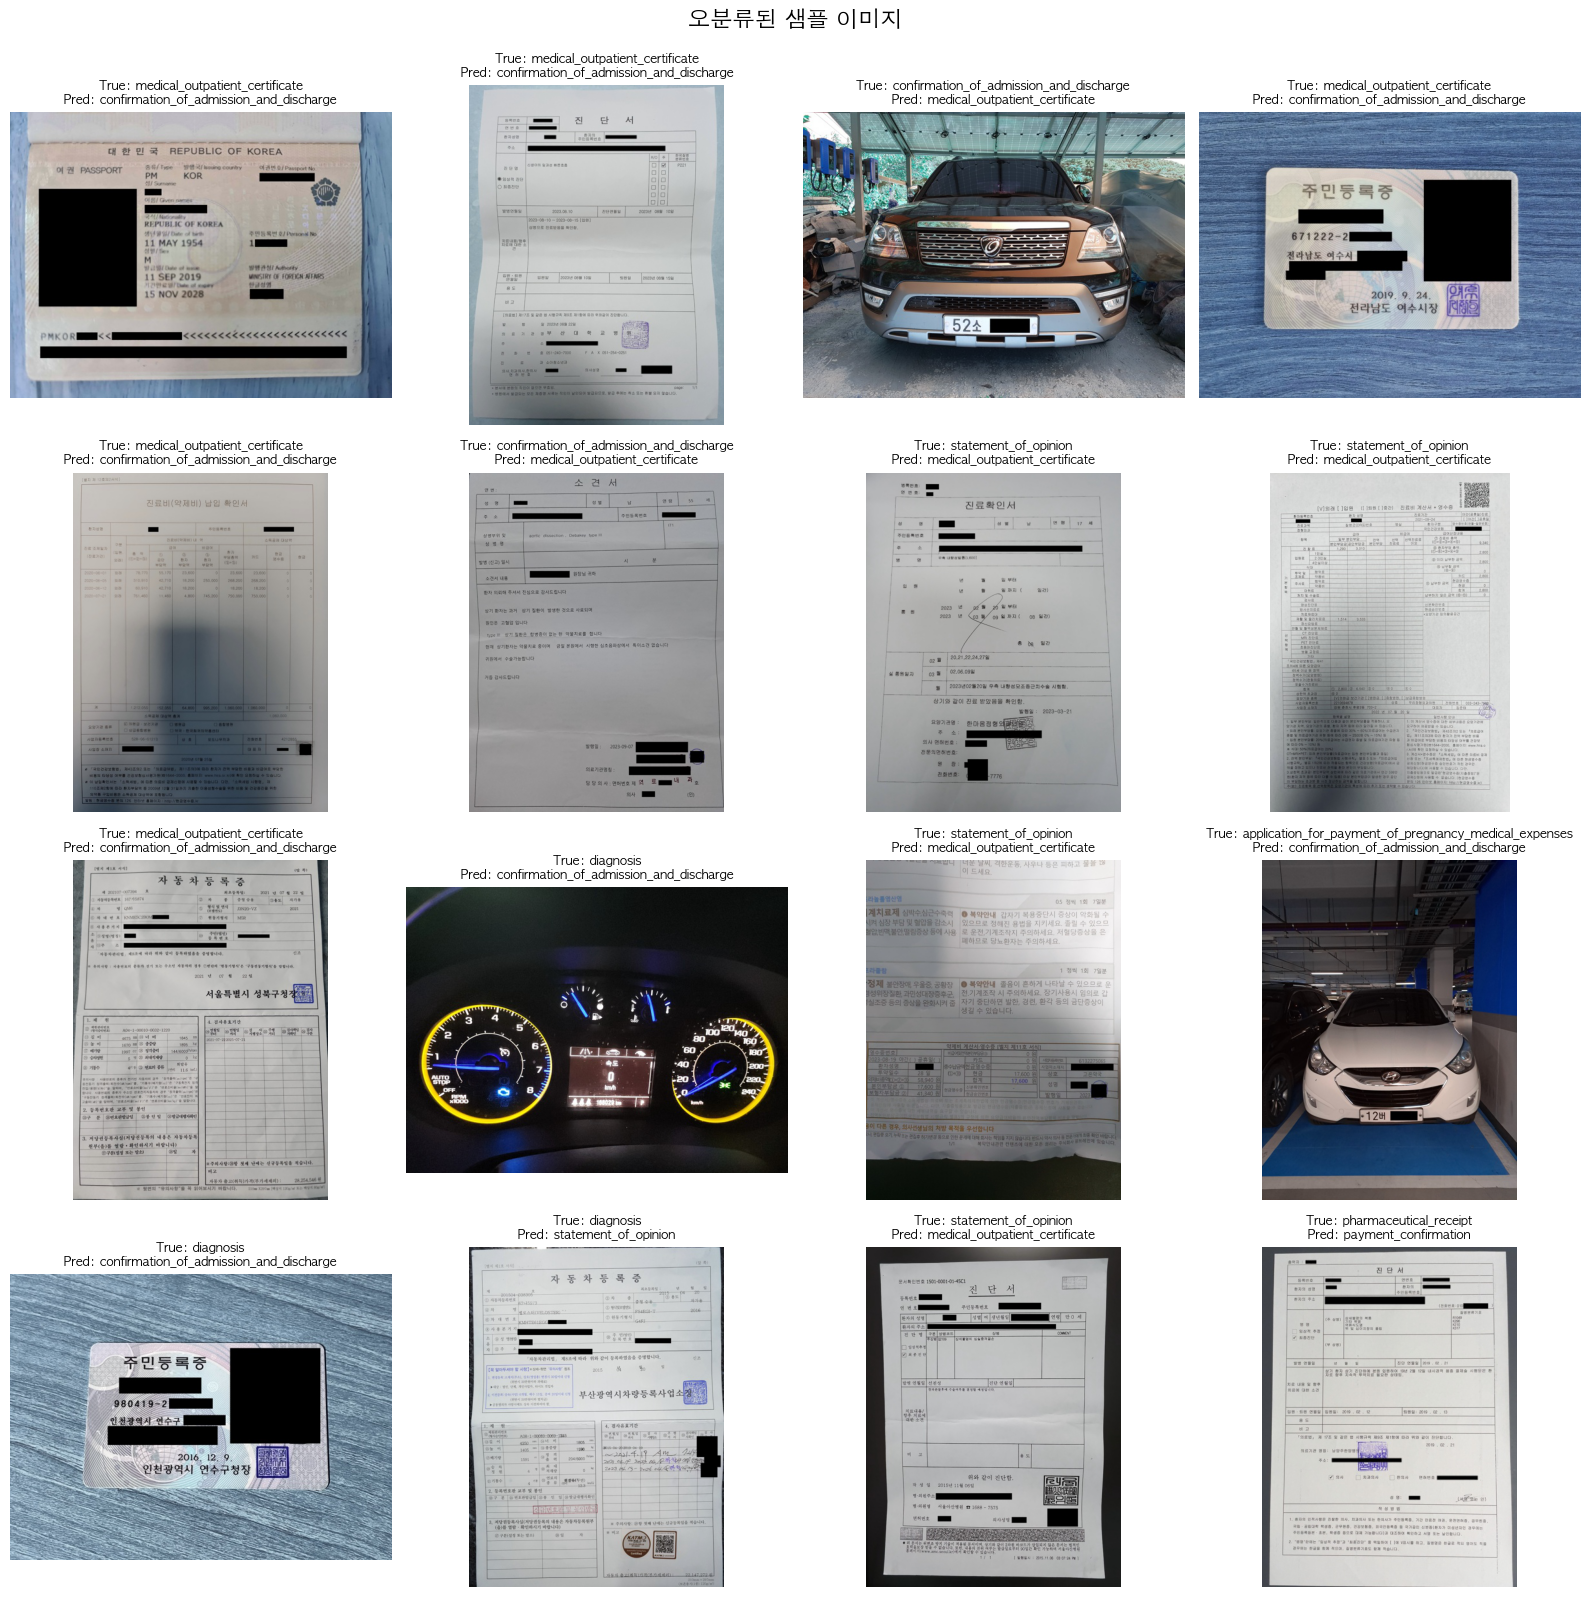


✅ 16개 오분류 샘플 시각화 완료!

📊 클래스별 오분류 비율 시각화...


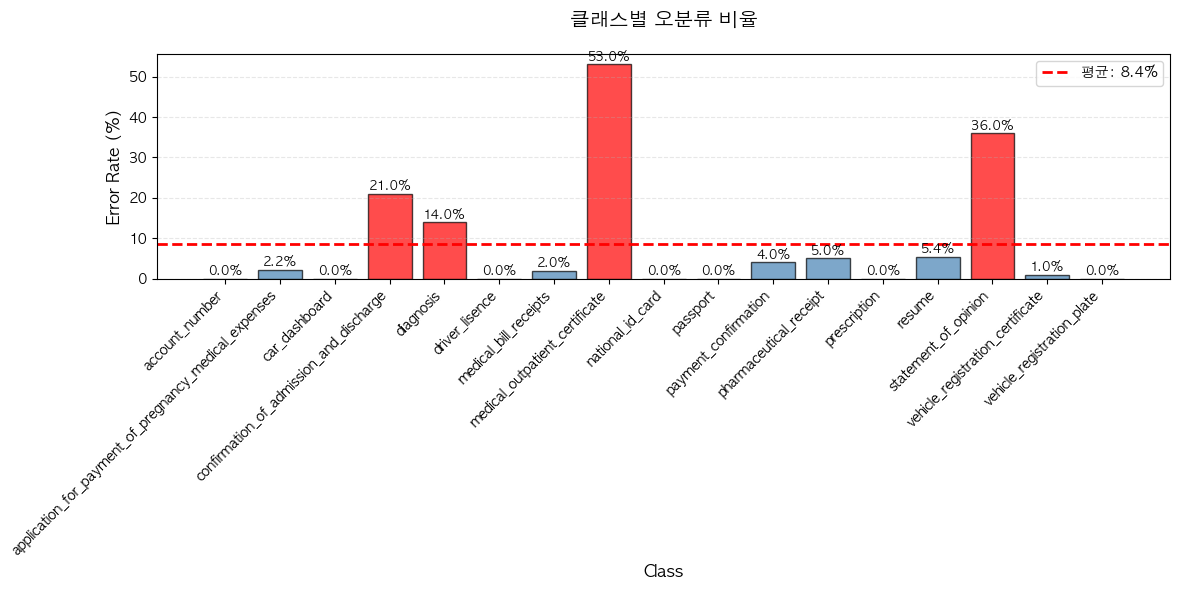

✅ 클래스별 오분류 비율 시각화 완료!

🔮 Test 데이터 예측 (제출용)
✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)


Fold 1 예측: 100%|██████████| 50/50 [00:12<00:00,  3.89it/s]


✅ Fold 1 Test 예측 완료!
✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)


Fold 2 예측: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


✅ Fold 2 Test 예측 완료!
✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)


Fold 3 예측: 100%|██████████| 50/50 [00:12<00:00,  4.14it/s]


✅ Fold 3 Test 예측 완료!
✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)


Fold 4 예측: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


✅ Fold 4 Test 예측 완료!
✅ 모델 생성 완료: EfficientNet-B0 (efficientnet_b0)


Fold 5 예측: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]

✅ Fold 5 Test 예측 완료!

✅ Test 예측 완료: 3,140개 샘플

✅ 전체 평가 완료!

🎉 최종 평가 결과
Validation 정확도: 92.17%
Validation F1 Score: 0.9171
Test 예측 완료: 3,140개 샘플


In [23]:
# ============================================================
# 8. 평가 및 결과 분석
# ============================================================
import platform
import matplotlib.pyplot as plt

# 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

from src.evaluation import run_full_evaluation

# Config 기반으로 전체 평가 실행
results = run_full_evaluation(
    fold_results=fold_results,
    test_dataset=test_dataset,
    class_names=class_names,
    config=config,
    train_dataset_raw=train_dataset_raw,  # ✅ 추가
    train_labels=train_labels       
)

# 결과 출력
# 결과 출력
print("\n" + "="*70)
print("🎉 최종 평가 결과")
print("="*70)
print(f"Validation 정확도: {results['test_acc']:.2f}%")
print(f"Validation F1 Score: {results['test_f1']:.4f}")
print(f"Test 예측 완료: {len(results['predictions']):,}개 샘플")
print("="*70)

In [24]:
# ============================================================
# 9. 제출파일 저장 (sample_submission.csv 기반)
# ============================================================
from src.submission import save_submission

# predictions를 포함한 results dict에서 예측값 추출
preds = results['predictions']

# sample_submission.csv 위치와 저장 경로 지정
sample_path = "data/sample_submission.csv"  # 루트 기준 경로
save_path = "outputs/submission.csv"   # 결과 제출 파일 경로

save_submission(
    preds=preds,
    sample_path=sample_path,
    save_path=save_path
)

📝 Submission 파일 생성 중...

✅ Submission 파일 생성 완료!
📁 저장 위치: outputs/submission.csv
📊 예측 샘플 수: 3,140
📋 컬럼: ['ID', 'target']

미리보기:
                     ID  target
0  0008fdb22ddce0ce.jpg       2
1  00091bffdffd83de.jpg       6
2  00396fbc1f6cc21d.jpg       9
3  00471f8038d9c4b6.jpg       6
4  00901f504008d884.jpg       2


ID  target
0     0008fdb22ddce0ce.jpg       2
1     00091bffdffd83de.jpg       6
2     00396fbc1f6cc21d.jpg       9
3     00471f8038d9c4b6.jpg       6
4     00901f504008d884.jpg       2
...                    ...     ...
3135  ffb4b6f619fb60ea.jpg       6
3136  ffb54299b1ad4159.jpg      11
3137  ffc2c91dff8cf2c0.jpg       8
3138  ffc4e330a5353a2a.jpg       0
3139  ffc71fed753d90c1.jpg      12

[3140 rows x 2 columns]

In [ ]:
# ============================================================
# 10. Wandb 종료 및 실험 완료
# ============================================================
if config.USE_WANDB:
    import wandb
    wandb.finish()
    print("\n✅ Wandb 종료 완료")
else:
    print("\n⏭️  Wandb 미사용")

print("\n" + "="*70)
print("🎉 모든 실험이 완료되었습니다!")
print("="*70)

In [ ]:
# ============================================================
# 10. 실험 결과 저장
# ============================================================
from src.logger import log_experiment_results

log_experiment_results(
    fold_results=fold_results,
    results=results,
    config=config
)

print("\n🎉 모든 작업 완료!")